In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("data.csv", encoding="latin1")

In [4]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
df = df.dropna(subset=['CustomerID'])

In [7]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [8]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [13]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalAmount  397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


Top 10 countries by revenue


In [14]:
df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)

Country
United Kingdom    7308391.554
Netherlands        285446.340
EIRE               265545.900
Germany            228867.140
France             209024.050
Australia          138521.310
Spain               61577.110
Switzerland         56443.950
Belgium             41196.340
Sweden              38378.330
Name: TotalAmount, dtype: float64

 Top 10 customers by total spend

In [15]:
df.groupby('CustomerID')['TotalAmount'].sum().sort_values(ascending=False).head(10)

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
12415.0    124914.53
14156.0    117379.63
17511.0     91062.38
16029.0     81024.84
12346.0     77183.60
Name: TotalAmount, dtype: float64

 Monthly sales trend

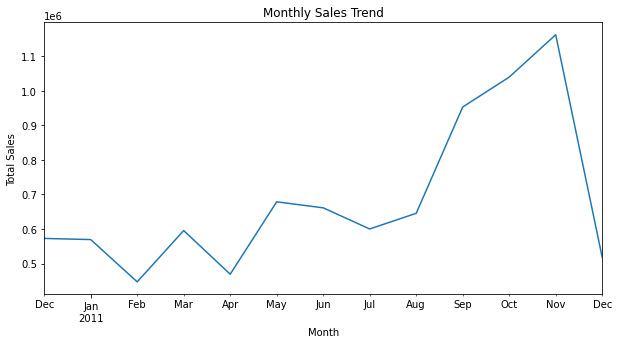

In [17]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')

monthly_sales = df.groupby('Month')['TotalAmount'].sum()

monthly_sales.plot(kind='line', figsize=(10,5), title='Monthly Sales Trend')
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

Set reference date

In [16]:
latest_date = df['InvoiceDate'].max()
latest_date

Timestamp('2011-12-09 12:50:00')

Create RFM table

In [17]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


RFM score calculation

In [23]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'], 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

Combine scores

In [21]:
rfm['RFM_Score'] = rfm['R_score'].astype(str) + \
                   rfm['F_score'].astype(str) + \
                   rfm['M_score'].astype(str)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,12346.0,325,1,77183.60,1,1,4,114
1,12347.0,1,182,4310.00,4,4,4,444
2,12348.0,74,31,1797.24,2,2,4,224
3,12349.0,18,73,1757.55,3,3,4,334
4,12350.0,309,17,334.40,1,1,2,112


Customer Segmentation

In [25]:
def segment_customer(row):
    if row['R_score'] == 4 and row['F_score'] == 4 and row['M_score'] == 4:
        return 'Best Customers'
    elif row['R_score'] >= 3 and row['F_score'] >= 3:
        return 'Loyal Customers'
    elif row['F_score'] >= 3:
        return 'Potential Loyalists'
    else:
        return 'At Risk'


In [26]:
rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Customer_Segment
0,12346.0,325,1,77183.60,1,1,4,114,At Risk
1,12347.0,1,182,4310.00,4,4,4,444,Best Customers
2,12348.0,74,31,1797.24,2,2,4,224,At Risk
3,12349.0,18,73,1757.55,3,3,4,334,Loyal Customers
4,12350.0,309,17,334.40,1,1,2,112,At Risk


Segment distribution

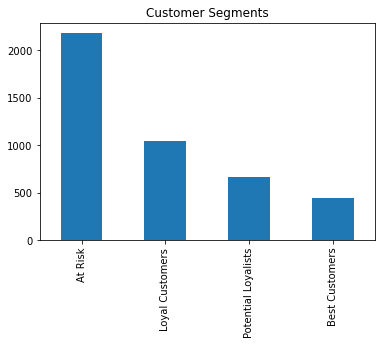

In [28]:
rfm['Customer_Segment'].value_counts().plot(kind='bar', title='Customer Segments')
plt.show()

Customer Segmentation Results:

-Best Customers: High recency, frequency, and monetary value

-Loyal Customers: Frequent and recent buyers

-Potential Loyalists: High purchase frequency but lower recency

-At-Risk Customers: Low engagement

>>Business Insights 
Key Insights from the Analysis

-A small group of customers contributes to a large portion of total revenue, indicating the presence of high-value customers.

-Best Customers and Loyal Customers show high purchase frequency and recent activity, making them ideal targets for loyalty programs.

-A significant number of customers fall under the At-Risk category, indicating potential churn.

-Sales show seasonal trends, with higher revenue observed during specific months.

-Customers from a few countries contribute to the majority of overall sales.

>>Business Recommendations (VERY IMPORTANT)
Actionable Recommendations

-Introduce exclusive discounts or rewards for Best and Loyal Customers to increase retention.

-Run re-engagement campaigns (emails, offers) for At-Risk customers to reduce churn.

-Use customer segmentation for personalized marketing instead of mass promotions.

-Optimize inventory based on top-selling products and peak months.

-Expand marketing strategies in high-revenue countries.

>>Project Summary

This project analyzes e-commerce customer purchasing behavior using real transactional data. Data cleaning and exploratory analysis were performed to understand sales trends and customer activity. Customers were segmented using RFM analysis to identify high-value and churn-prone groups. The insights derived can help businesses improve customer retention, optimize marketing strategies, and increase overall revenue.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("data.csv", encoding="latin1")


In [5]:
import os
os.listdir()


['.ipynb_checkpoints',
 'cleaned_ecommerce_data.csv',
 'data.csv',
 'desktop.ini',
 'ecommerce_customer_analysis.ipynb',
 'PowerBI',
 'rfm_customer_segments.csv']

In [6]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove invalid quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalAmount  397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [8]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Save cleaned transaction data as CSV

In [12]:
df.to_csv("cleaned_ecommerce_data.csv", index=False)


Save RFM customer segmentation data

In [18]:
rfm.to_csv("rfm_customer_segments.csv", index=False)


Confirm files are created

In [19]:
import os
os.listdir()


['.ipynb_checkpoints',
 'cleaned_ecommerce_data.csv',
 'data.csv',
 'ecommerce_customer_analysis.ipynb',
 'rfm_customer_segments.csv']

In [9]:
df_sample = df.sample(5000, random_state=42)
df_sample.to_csv("data_sample.csv", index=False)
